# SimPEG(emg3d) -- work in progress

based on `simpeg-emg3d-inversion.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import SimPEG
import SimPEG.electromagnetics.frequency_domain as FDEM

In [2]:
%matplotlib widget

## Create a grid

Very small now, for dev purposes.

In [3]:
frequency = 2.
seafloor = -2000.
#min_cell = 100.  # => 81,920 cells, 5 sources, 41 receivers
min_cell = 200.  # => 18,432 cells, 3 sources, 21 receivers

mesh = emg3d.construct_mesh(
    center=(min_cell/2, 0, seafloor),  # Smallest cell at center
    frequency=1.,          # Reference frequency
    properties=(0.3, 1, 1, 0.3),  # Reference resistivity
    min_width_limits=min_cell,
    # Domain in which we want precise results
    domain=([-2000, 2000],    # x-dir: where we have receivers
            [-1000, 1000],    # y-dir: just extent of target
            [seafloor-1000, seafloor+500]),  # 
    mapping='Conductivity',
    center_on_edge=True,
)

# Active cells for inversion: everything below water
inds_active = mesh.cell_centers[:, 2] < seafloor

mesh

TensorMesh: 18,432 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     32     -5,197.13      6,729.30    200.00  1,532.17    1.40
   y     24     -4,186.99      4,186.99    200.00    746.72    1.21
   z     24     -6,449.09      4,341.71    200.00  1,263.28    1.23

## Create a model

Deep marine scenario, so we can ignore the air layer for developing.

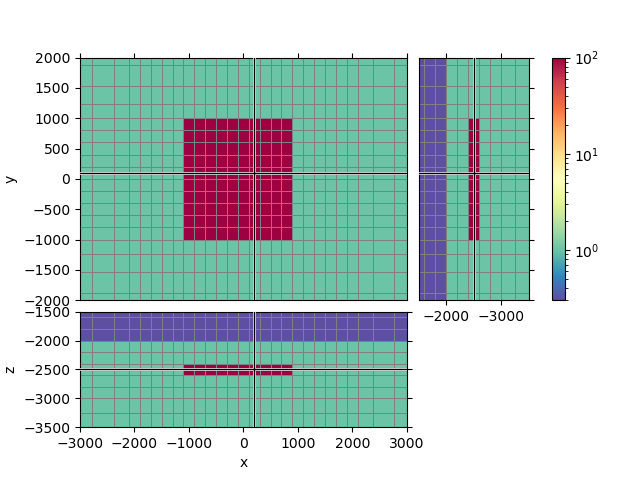

Model: conductivity; isotropic; 32 x 24 x 24 (18,432)

In [4]:
# Initiate with background resistivity
sigma = np.ones(mesh.n_cells)

# Add water layer
sigma[mesh.cell_centers[:, 2] > seafloor] = 1/0.3

# Add target
inds_target = (
    (abs(mesh.cell_centers[:, 0]) < 1000) &
    (abs(mesh.cell_centers[:, 1]) < 1000) &
    np.logical_and(mesh.cell_centers[:, 2] < seafloor-500,
                   mesh.cell_centers[:, 2] > seafloor-700) 
)
sigma[inds_target] = 1/100.

# Create model
model = emg3d.Model(mesh, sigma, mapping='Conductivity')

# QC
mesh.plot_3d_slicer(
    1/sigma,  # Plot resistivities, not conductivities
    pcolor_opts={'edgecolors': 'grey', 'linewidth': 0.5,
                 'cmap':'Spectral_r',
                 'norm':LogNorm(vmin=0.3, vmax=100)}, 
    xlim=[-3000, 3000],
    ylim=[-2000, 2000],
    zlim=[seafloor-1500, seafloor+500],
    zslice=seafloor-500,
)

# QC
model

## Create a survey

For now, we have sources and receivers on the corresponding edges. However, this has to become flexible!

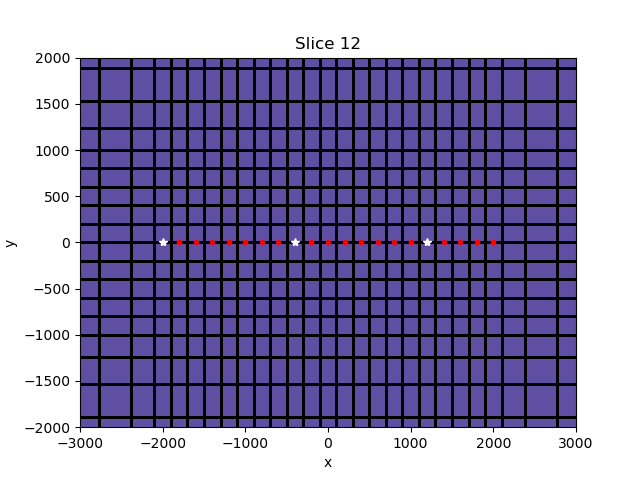

In [5]:
# Receiver line
rec_x = mesh.cell_centers_x[abs(mesh.cell_centers_x) < 2100]
xyz_rx = SimPEG.utils.ndgrid(rec_x, 0, seafloor+100)

# Source line
# xyz_src = SimPEG.utils.ndgrid(rec_x[::5], 0, seafloor+100)  # 8 sources
xyz_src = SimPEG.utils.ndgrid(rec_x[::8], 0, seafloor+100)  # 5 sources

# QC
mesh.plot_slice(
    1./sigma, grid=True, normal='Z', 
    ind=12,
    pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=1, vmax=100)}, 
    range_x=(-3000, 3000),
    range_y=(-2000, 2000),
)
plt.plot(xyz_rx[:,0], xyz_rx[:,1], 'r.')
plt.plot(xyz_src[:,0], xyz_src[:,1], 'w*')

### For now we only have one receiver list.

**However, we have to test with arbitrary source/receiver/frequency combination, if the interaction SimPEG(emg3d) works.**

In [6]:
rx_list = [
    FDEM.receivers.PointElectricField(
        orientation='x', component="complex", locations=xyz_rx),
]

src_list = []
for ii in range(xyz_src.shape[0]):
    src = FDEM.sources.ElectricDipole(
        rx_list, location=xyz_src[ii,:], frequency=frequency, azimuth=0, elevation=0)
    src_list.append(src)

survey = FDEM.Survey(src_list)

## Create SimPEG-Simulation

In [7]:
active_map = SimPEG.maps.InjectActiveCells(mesh, inds_active, sigma[~inds_active])
nP = int(inds_active.sum())
conductivity_map = active_map * SimPEG.maps.ExpMap(nP=nP)

In [8]:
# Define the Simulation
simulation = FDEM.Simulation3DEMG3D(
        mesh,
        survey=survey,
        sigmaMap=conductivity_map,
        verbose=False,
#        simulation_opts={
#            'solver_opts': {
#                'maxit': 1,     # To speed up for testing
#                'plain': True   # " "  (fails faster)
#            },
#            'verb': -1,         # To not raise convergence warnings
#        },
)

# True and initial model
m_true =  np.log(sigma[inds_active])
m0 =  np.ones(m_true.shape) * np.log(1.)

## QC emg3d-Survey created by SimPEG

In [9]:
simulation.emg3d_survey

:: Survey «Survey created by SimPEG» ::

<xarray.Dataset> Size: 2kB
Dimensions:   (src: 3, rec: 21, freq: 1)
Coordinates:
  * src       (src) <U6 72B 'TxED-1' 'TxED-2' 'TxED-3'
  * rec       (rec) <U7 588B 'RxEP-01' 'RxEP-02' ... 'RxEP-20' 'RxEP-21'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 1kB (nan+nanj) ... (nan+nanj)
    indices   (src, rec, freq) int64 504B 0 1 2 3 4 5 6 ... 56 57 58 59 60 61 62
Attributes:
    noise_floor:     1.0
    relative_error:  None

## => Currently, `f` returns a emg3d-simulation, and `dpred` an ndarray. This should change to SimPEG fields- and data-objects, I think

In [10]:
f = simulation.fields(m_true)
d_true = simulation.dpred(m_true, f=f)

In [11]:
d_0 = simulation.dpred(m0)

In [12]:
relative_error = 0.01
noise_floor = 1e-14
standard_deviation = np.sqrt(abs(relative_error*d_true)**2 + (noise_floor)**2)

In [13]:
residual = (d_true - d_0)/standard_deviation

### Question @Seogi: Why are there less data per source than there are receivers?

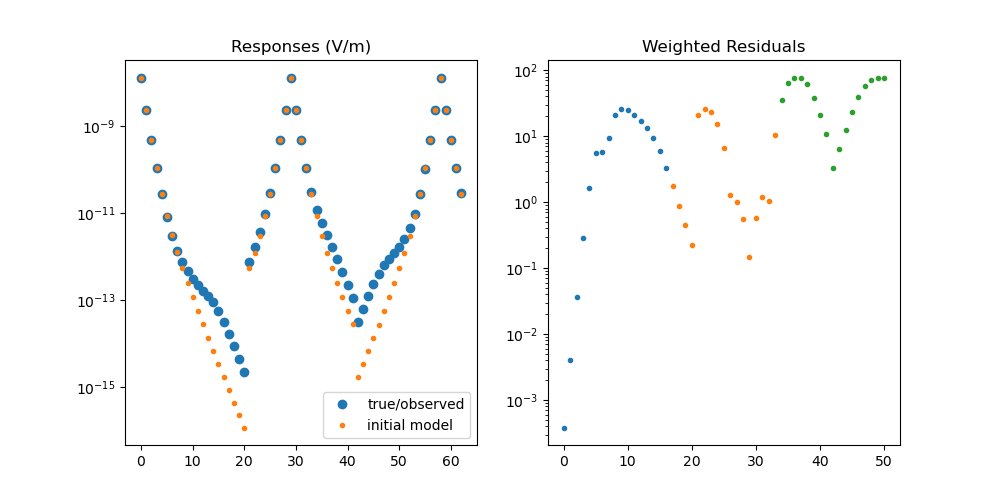

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Responses (V/m)')
ax1.semilogy(abs(d_true), 'o', label='true/observed')
ax1.semilogy(abs(d_0), '.', label='initial model')
ax1.legend()

ax2.set_title('Weighted Residuals')
nsrc = xyz_src.shape[0]
nrec = len(rec_x)-4
x = np.arange(len(residual))
for s in range(nsrc):
    ax2.semilogy(x[s*nrec:(s+1)*nrec], abs(residual[s*nrec:(s+1)*nrec]), '.')

plt.show()

In [15]:
em_data = SimPEG.data.ComplexData(survey, dobs=d_true, standard_deviation=standard_deviation)
dmis = SimPEG.data_misfit.L2DataMisfit(data=em_data, simulation=simulation)

In [16]:
adjoint_tol = 1e-10
def test_misfit():
    passed = SimPEG.tests.checkDerivative(
        lambda m: (simulation.dpred(m), lambda mx: simulation.Jvec(m0, mx, f=f)),
        m0,
        plotIt=False,
        num=3,
    )

def test_adjoint():
    # Adjoint Test
    f = simulation.fields(m=m0)
    # u = np.random.rand(.mesh.nC * .survey.nSrc)
    v = np.random.rand(inds_active.sum())
#     v = np.random.rand(mesh.nC)
    w = np.random.rand(simulation.survey.nD)
    wtJv = np.vdot(w, simulation.Jvec(m0, v, f=f)).real
    vtJtw = np.vdot(v, simulation.Jtvec(m0, w, f=f))
    passed = np.abs(wtJv - vtJtw) < adjoint_tol
    print("Adjoint Test", np.abs(wtJv - vtJtw), passed)
    print(wtJv, vtJtw)
    
def test_dataObj():
    passed = SimPEG.tests.checkDerivative(
        lambda m: [dmis(m), dmis.deriv(m)], m0, plotIt=False, num=2
    )    

In [17]:
test_dataObj()

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    5.976e+02     3.409e+02      nan
 1   1.00e-02    2.907e+01     3.393e+00      2.002
========================= PASS! =========================
You deserve a pat on the back!



In [18]:
test_misfit()

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.094e-10     1.204e-11      nan
 1   1.00e-02    1.092e-11     1.209e-13      1.998
 2   1.00e-03    1.092e-12     1.209e-15      2.000
========================= PASS! =========================
Yay passed!



In [19]:
test_adjoint()

Adjoint Test 1.4087358048510253e-17 True
-3.470250850855762e-10 -3.4702509917293424e-10


In [20]:
%%time

# Define the regularization (model objective function)
reg = SimPEG.regularization.Tikhonov(
    mesh,
    indActive=inds_active,
    mref=m0,
    alpha_s=1e-8,
    alpha_x=1,
    alpha_y=10,
    alpha_z=1
)

nit = 20
#nit = 2
opt = SimPEG.optimization.InexactGaussNewton(
    maxIter=nit, maxIterLS=nit, maxIterCG=nit, tolCG=1e-3,
)

inv_prob = SimPEG.inverse_problem.BaseInvProblem(dmis, reg, opt)
starting_beta = SimPEG.directives.BetaEstimate_ByEig(beta0_ratio=1)
save = SimPEG.directives.SaveOutputDictEveryIteration()

beta_schedule = SimPEG.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = SimPEG.directives.TargetMisfit(chifact=1)

directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
    save
]
em_inversion = SimPEG.inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = em_inversion.run(m0)


            SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
            ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.53e-02  2.78e+04  0.00e+00  2.78e+04    7.75e+03      0              
   1  1.26e-02  1.05e+04  9.50e+04  1.17e+04    3.05e+03      0              
   2  6.31e-03  5.56e+03  7.22e+04  6.01e+03    5.86e+03      0              
   3  3.16e-03  1.63e+03  7.28e+04  1.86e+03    1.85e+03      0              
   4  1.58e-03  8.85e+02  9.59e+04  1.04e+03    9.96e+02      0   Skip BFGS  
   5  7.89e-04  6.92e+02  1.09e+05  7.78e+02    1.03e+03      1   Skip BFGS  
   6  3.95e-04  6.49e+02  1.53e+05  7.09e+02    1.30e+03      0   Skip BFGS  
   7  1.97e-04  3.85e+02  

In [21]:
target_misfit.target

31.5

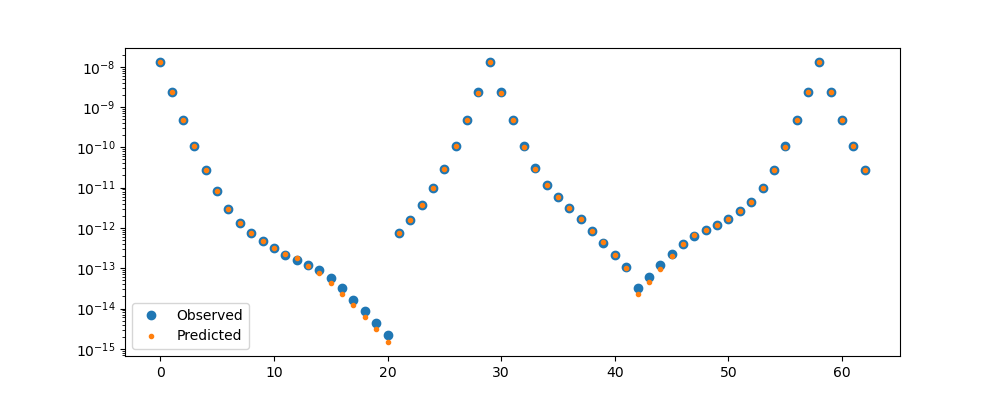

In [22]:
plt.figure(figsize=(10, 4))
iteration = len(save.outDict.keys())
plt.semilogy(abs(em_data.dobs), 'o', label='Observed')
plt.semilogy(abs(save.outDict[iteration]['dpred']), '.', label='Predicted')
plt.legend()

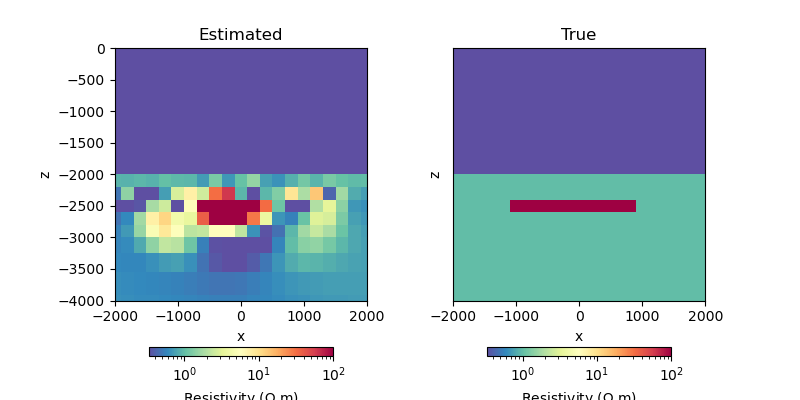

In [23]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

sigm_est = conductivity_map * save.outDict[iteration]['m']
sigmas = [sigm_est, sigma]
titles = ["Estimated", "True"]
for ii, ax in enumerate(axs):
    out = mesh.plot_slice(
        1./sigmas[ii], grid=False, normal='Y', 
        pcolor_opts={'cmap':'Spectral_r', 'norm':LogNorm(vmin=0.33, vmax=100)}, 
        ax=ax,
    )
    ax.set_aspect(1)
    ax.set_ylim(-4000, 0)
    ax.set_xlim(-2000, 2000)
    if ii == 1:
        ax.set_yticks([])
    ax.set_title(titles[ii])
    cb = plt.colorbar(out[0], ax=ax, fraction=0.03, orientation='horizontal')
    cb.set_label("Resistivity ($\Omega$ m)")

In [24]:
emg3d.Report('SimPEG')

--------------------------------------------------------------------------------
  Date: Fri Aug 09 10:49:13 2024 CEST

                OS : Linux
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21)
  [GCC 12.3.0]

            SimPEG : 0.16.0
             numpy : 1.26.4
             scipy : 1.13.1
             numba : 0.60.0
             emg3d : 1.8.3
           empymod : 2.3.1
            xarray : 2024.3.0
        discretize : 0.7.4
              h5py : 3.11.0
        matplotlib : 3.5.3
              tqdm : 4.66.5
           IPython : 8.18.1
--------------------------------------------------------------------------------